# Проект A/B-тестирование

### Условие 
В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

### Входные данные

В качестве входных данных имеются 4 csv-файла:

- `groups.csv` - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
- `groups_add.csv` - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
- `active_studs.csv` - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
- `checks.csv` - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

### Вопросы

- На какие метрики стоит смотреть в ходе анализа и почему?
- Имеются ли различия в показателях и с чем они могут быть связаны?
- Являются ли эти различия статистически значимыми?
- Стоит ли запускать новую механику на всех пользователей?

### План выполнения проекта:
    1. Исследование и подготовка данных
    2. A/B тестирование
    3. Интерпретация результатов A/B тестирования

## 1. Исследование и подготовка данных

In [93]:
# импортируем нужные библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
import pingouin as pg

In [2]:
# Настроим отображение графиков
sns.set_theme(font_scale = 1, 
              style = 'whitegrid', 
              rc = {'figure.figsize': (10, 5)}
)

Загрузим и посмотрим на данные

In [3]:
groups = pd.read_csv('groups.csv', sep=';')
groups_add = pd.read_csv('group_add.csv')
active_studs = pd.read_csv('active_studs.csv')
checks = pd.read_csv('checks.csv', sep=';')

In [4]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [5]:
groups.shape[0]

74484

In [6]:
# проверим наличие пропущенных значений
groups.isna().sum()

id     0
grp    0
dtype: int64

In [7]:
# посмотрим на пророрции распределения пользователей в контрольную и эксперементальную группы
groups.grp.value_counts(normalize=True).mul(100)

B    80.303152
A    19.696848
Name: grp, dtype: float64

В эксперементальной группе гораздо больше пользователей - 80%, против 20% в контрольной группе

In [8]:
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [9]:
groups_add.shape[0]

92

In [10]:
groups_add.grp.value_counts()

B    70
A    22
Name: grp, dtype: int64

В таблице groups_add содержится 70 дополнительных пользователей из эксперементальной группы и 22 из контрольной 

In [11]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [12]:
active_studs.shape[0]

8341

In [13]:
# посчитаем долю пользователей, которые зашли на платформу в дни проведения эксперемента
round(active_studs.shape[0] / (groups.shape[0] + groups_add.shape[0]), 2)

0.11

In [14]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [15]:
checks.shape[0]

541

Соединим основной файл с пользователями с дополнительным

In [16]:
groups_full = pd.concat([groups, groups_add])
groups_full

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
87,200247820,B
88,201032527,B
89,201067612,B
90,201067653,B


Оставим информацию лишь об активных пользователях (заходили на платформу в дни проведения эксперимента).

In [17]:
# Чтобы объеденить таблицы, переименум столбец student_id в таблице active_studs
active_studs.rename(columns={'student_id': 'id'}, inplace=True)

In [18]:
active_users = active_studs.merge(groups_full, on='id', how='left')
active_users.head()

,id,grp
0,581585,A
1,5723133,A
2,3276743,B
3,4238589,A
4,4475369,B


In [19]:
active_users.shape[0]

8341

Добавим в таблицу с активными пользователями информацию об оплатах

In [20]:
# переименуем столбец
checks.rename(columns={'student_id': 'id'}, inplace=True)

In [21]:
active_checks = active_users.merge(checks, on='id', how='left')
active_checks.head()

,id,grp,rev
0,581585,A,NaN
1,5723133,A,NaN
2,3276743,B,NaN
3,4238589,A,NaN
4,4475369,B,NaN


In [22]:
active_checks.shape[0]

8341

In [23]:
# заменим NaN значения на нули, для удобства дальнейшего анализа
active_checks.fillna(0, inplace=True)

## 2. A/B тестирование

В качестве первой метрики для сравнения выбираем среднюю прибыль на пользователя - ARPU. 
Попробуем сравнить метрику при помощи t-теста и bootstrap

Для *максимально точного* t-теста необходимо

- нормальное распределение данных (при условии, что у нас n>30, этим условием можно и принебречь, так как распределение выборочных средних все равно будет стремиться к нормальному, согласно ЦПТ)
- приблиизительное равенство дисперсий
- приблизительное равенство выборок

### Размеры выборок

Посмотрим сколько студентов попало в экспериментальную и контрольную группы из тех, кто заходил на платформу в дни эксперимента

In [24]:
active_checks.grp.value_counts()

B    6803
A    1538
Name: grp, dtype: int64

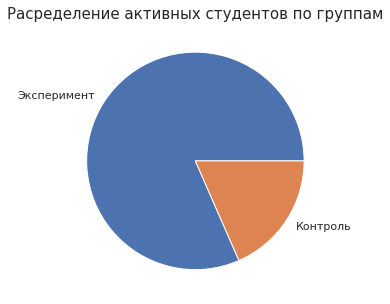

In [25]:
plt.figure(figsize=(10, 5))
plt.pie(active_checks.grp.value_counts(), labels=['Эксперимент', 'Контроль'])
plt.title('Расределение активных студентов по группам', fontsize=15)
plt.show()

Видим, что присутствует дисбаланс в группах - в эксперемнтальной группе в 4.5 раза больше наблюдений, чем в контрольной. Это не помешает сравнению двух групп, однако может уменьшить мощность статистического теста (подробнее о влиянии дисбаланса на мощность теста [здесь](https://medium.com/statistics-experiments/дисбаланс-в-a-b-тестах-есть-ли-разница-между-99-1-и-50-50-в-экспериментах-11c8f4fe7eb4))

### Нормальность расределения

In [26]:
# Создадим отдельные переменные для двух групп
control = active_checks.query('grp == "A"').rev
treatment = active_checks.query('grp == "B"').rev

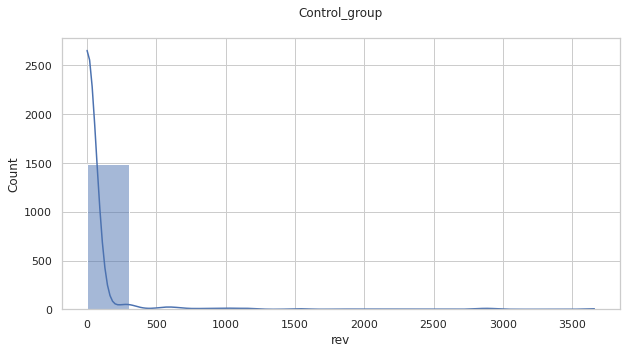

In [27]:
# Проверим нормальность распределения в группах при помощи теста Агостино-Пирсона функциeй
# scipy.stats.normaltest()
ax = sns.histplot(control, kde = True)
ax.set_title('Control_group\n')
plt.show()

In [28]:
ss.normaltest(control) 

NormaltestResult(statistic=2240.5957974074026, pvalue=0.0)

Визуально и согласно тесту, распределение сильно скошено влево- большинство пользователей сделали покупок на 0 руб

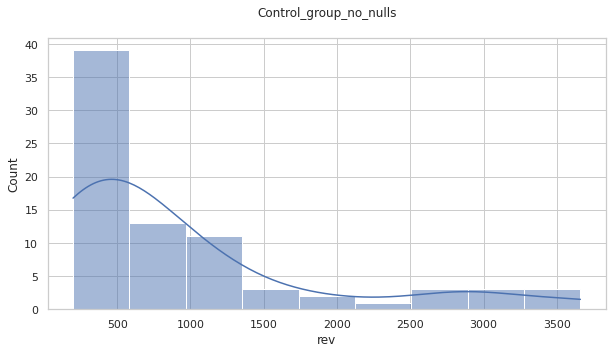

In [29]:
# попробуем избавиться от нулевых значений
ax = sns.histplot(active_checks.query('grp == "A" & rev > 0').rev, kde = True)
ax.set_title('Control_group_no_nulls\n')
plt.show()

Так стало лучше, однако, распределение все еще далеко от нормального

Text(0.5, 1.0, 'Сontrol_group_log\n')

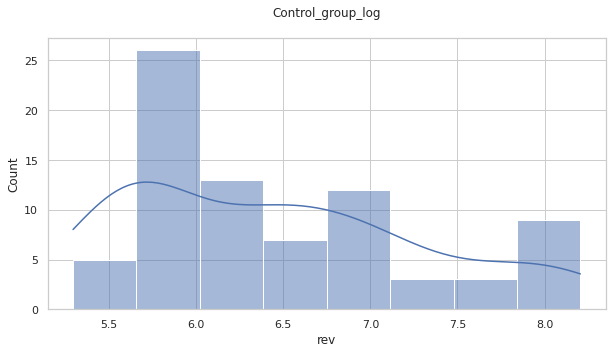

In [30]:
# поробуем воспользоваться логорифмированием
ax = sns.histplot(np.log(active_checks.query('grp == "A" & rev > 0').rev), kde = True)
ax.set_title('Сontrol_group_log\n')

Логарифмирование в нашем случае также не исправляет ситуацию

Text(0.5, 1.0, 'Treatment_group\n')

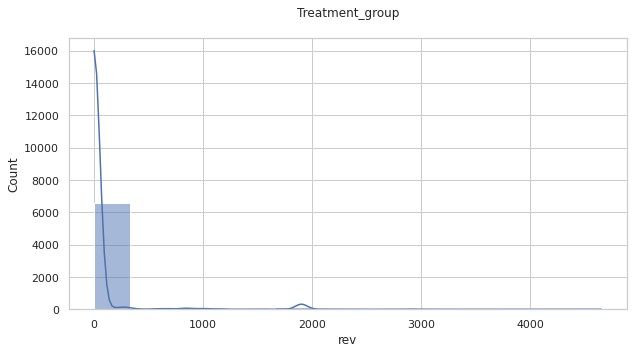

In [31]:
# теперь проверяем распределение величины чеков в тестовой группе
ax = sns.histplot(treatment, kde = True)
ax.set_title('Treatment_group\n') 

In [32]:
ss.normaltest(treatment)

NormaltestResult(statistic=7797.399211581946, pvalue=0.0)

В тествовой группе ситуация таже - скошенное расределение, большинство пользователей сделали покупок на 0 руб

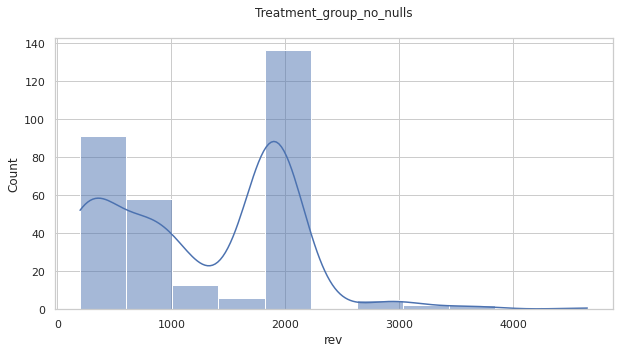

In [33]:
# попробуем избавиться от нулевых значений
ax = sns.histplot(active_checks.query('grp == "B" & rev > 0').rev, kde = True)
ax.set_title('Treatment_group_no_nulls\n')
plt.show()

Очевидно, что и без нулевых значений распределение размера чека в тестовой группе не является нормальным

### Стандартные отклонения

In [34]:
# Проверим однородность стандартных отклонений в двух выборках
active_checks.groupby('grp', as_index=False).agg(std = ('rev', 'std'))

,grp,std
0,A,290.490632
1,B,313.770201


Стандартное отклонение двух выборок достаточно велико (за счет большого количества нулевых значений) и приблизительно равно (290 и 313)

### Различия в ARPU t-тест

In [35]:
# посмотрим на среднее в двух группах (в нашем случае ARPU)
ARPU = active_checks.groupby('grp', as_index=False).agg(mean = ('rev', 'mean'))
ARPU

,grp,mean
0,A,47.347204
1,B,58.058798


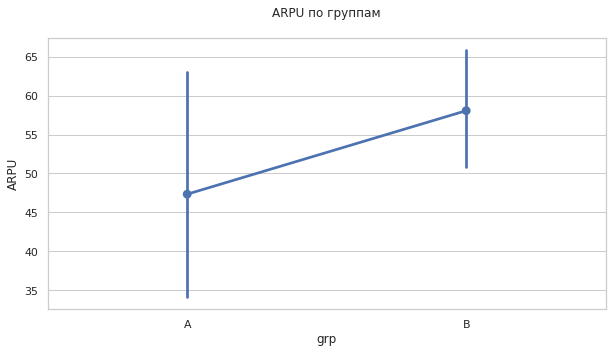

In [36]:
sns.pointplot(data=active_checks, x='grp', y='rev')
plt.title('ARPU по группам\n')
plt.ylabel('ARPU')
plt.show()

In [37]:
# на сколько изменилось среднее в абсолютных цифрах 
treatment.mean()-control.mean()

10.711593942529369

In [38]:
# ... в процентах
(treatment.mean()-control.mean()) / (control.mean()/100)

22.623498329593748

Видим, что между группами имеются значительные различия в ARPU - более 22% процентов. Однако являются ли эти различия статистически значимыми?.. Выясним это при помощи t-теста

In [39]:
# запускаем t-тест
ss.ttest_ind(treatment, control)

Ttest_indResult(statistic=1.225341107379344, pvalue=0.22048133326988403)

Pvalue > 0.05, следовательно, у нас нет оснований, чтобы отвергнуть нулевую гипотезу о равенстве метрик в двух группах, несмотря наlift более, чем в 22% в эксперементальной группе. Вероятнее всего, такой результат - следствие высокого стандартного отклонения в двух группах, обусловленного большим количеством нулей в данных. 

P.S.: учитывая ненормальность распределения данных, хотелось бы применить тест Mанна-Уитни, однако в нашем случае это невозможно из-за большого количества совпадающих значения в выборках (нули).

### Bootstrap ARPU

Попробуем найти доверительный интервал разницы в ARPU между группами при помощи бутстрапа

In [43]:
# строим 95% доверительный интервал для разницы средних двух групп (разниц ARPU)


n = 1500         # размер исходной выборки
B = 1000        # количество генерируемых подвыборок

mean_diff = treatment.mean() - control.mean()
bootstrap_values_control = np.random.choice(control, (B, n), replace=True)
bootstrap_means_control = np.mean(bootstrap_values_control, axis=1)
bootstrap_values_treatment = np.random.choice(treatment, (B, n), replace=True)
bootstrap_means_treatment = np.mean(bootstrap_values_treatment, axis=1)
bootstrap_stats = bootstrap_means_treatment - bootstrap_means_control 

In [44]:
# строим перцентильный доверительный интервал для разниц средних в наших бут-выборках

alpha = 0.05
left, right = np.quantile(bootstrap_stats, [alpha / 2, 1 - alpha / 2])
has_effect = not (left < 0 < right)

In [45]:
print(f'Значение среднего в тестовой группе изменилось на: {mean_diff:0.2f}')
print(f'{((1 - alpha) * 100)}% доверительный интервал: ({left:0.2f}, {right:0.2f})')
print(f'Отличия статистически значимые: {has_effect}')

Значение среднего в тестовой группе изменилось на: 10.71
95.0% доверительный интервал: (-10.91, 32.53)
Отличия статистически значимые: False


Как видно, 0 входит в 95% доверительный интервал для разницы ARPU. Следовательно, бутстрап таакже показал отсутствие статистически значимой разницы в метрике между группами.

### Конверсия

Посмотрим имеется ли статистически значимая разница в конверсии между двумя группами

In [52]:
# добавим в таблицу с покупками поле с конверсией
active_checks['cr'] = np.where(active_checks.rev > 0, 1, 0)
active_checks.tail()

,id,grp,rev,cr
8336,1794344,B,0.0,0
8337,296883,B,0.0,0
8338,3598448,B,0.0,0
8339,3610547,B,290.0,1
8340,205705,B,0.0,0


In [56]:
# посмотрим на конверсию в двух группах
cr = active_checks.groupby('grp', as_index=False).agg(cr = ('cr', 'mean'))
cr

,grp,cr
0,A,0.050715
1,B,0.046156


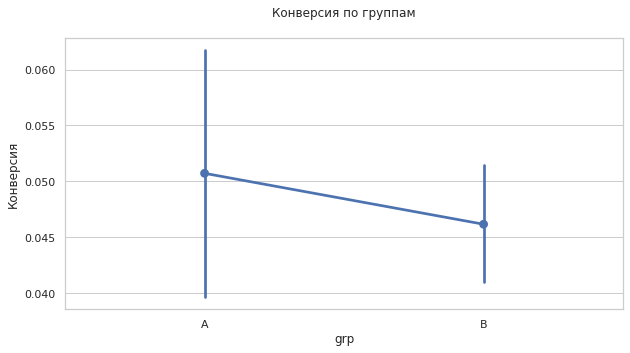

In [57]:
sns.pointplot(data=active_checks, x='grp', y='cr')
plt.title('Конверсия по группам\n')
plt.ylabel('Конверсия')
plt.show()

Мы видим, что конверсия в контрольной группе была выше, чем в экспериментальной (5% против 4.6%). Проверим значимость этих различий при помощи t-теста

In [58]:
# создадим отдельные переменные для двух групп
control_cr = active_checks.query('grp == "A"').cr
treatment_cr = active_checks.query('grp == "B"').cr

In [59]:
# запускаем t-тест
ss.ttest_ind(treatment_cr, control_cr)

Ttest_indResult(statistic=-0.7629235937766906, pvalue=0.445530545137386)

Pvalue > 0.05, значит у нас нет оснований для отклонения нулевой гипотезы о равенстве конверсий в двух группах.

### Различия в ARPPU t-тест

Также попробуем выяснить есть ли статистически значимые различия в средней прибыли на каждого платящего пользователя (ARPPU)

In [62]:
# создадим отдельные переменные для двух групп
control_arppu = active_checks.query('grp == "A" & cr == 1').rev
treatment_arppu = active_checks.query('grp == "B" & cr == 1').rev

In [77]:
# сравним стандартное отклоенение измерений в группах
print(f'STD в контроле {control_arppu.std():0.2f}')
print(f'STD в эксперименте {treatment_arppu.std():0.2f}')

STD в контроле 919.93
STD в эксперименте 790.86


Стандартные отклонения отличаются, поэтому будем использовать t-тест Уэлча

In [69]:
# посмотрим на различия в ARPPU между группами
print(f'ARPPU в контроле {control_arppu.mean():0.2f}')
print(f'ARPPU в эксперименте {treatment_arppu.mean():0.2f}')

ARPPU в контроле 933.59
ARPPU в эксперименте 1257.88


In [82]:
# различия в процентах
round((treatment_arppu.mean()-control_arppu.mean()) / (control_arppu.mean()/100), 0)

35.0

На первый взгляд, присутсвуют значительные различия в метриках. Выясним являются ли эти различия статистически значимыми при помощи t-теста

In [100]:
# запускаем t-тест
pg.ttest(treatment_arppu, control_arppu)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.86169,106.981668,two-sided,0.00507,"[99.64, 548.94]",0.39646,6.536,0.878211


Pvalue = 0.005, значит у нас есть основания для отклонения нулевой гипотезы о равенстве ARPPU в двух группах.

In [107]:
# вычселим 95% доверительный интервал в относительных величинах
left = round(99.64 / (control_arppu.mean()/100), 0)
right = round(548.94 / (control_arppu.mean()/100), 0)
print(f'95% доверительный интервал: {left:0.2f}% - {right:0.2f}%') 

95% доверительный интервал: 11.00% - 59.00%


## 3. Интерпретация результатов A/B тестирования

Для сравнения двух групп были выбраны три метрики - средняя прибыль с пользователя (ARPU), средняя прибыль с платящего платящего пользователя (ARPPU) и конверсия в покупку. 

ARPU оказался на 22% выше в тестовой группе. Мы проверили статистическую значимость этих результатов при помощи t-теста и метода бутстрап. Результаты не позволили отклонить нулевую гипотезу о равенстве ARPU в двух грппах (p-value 0.22; 95.0% доверительный интервал: -10.91 - 32.53). Таким образом, мы не нашли статистически значимых различий в ARPU между группами. 

Конверсия в покупку оказалась немного выше в контрольной группе (5% против 4.6%). Однко проведенный t-тест указал на отсутсвие статистически значимых различий в конверсии двух групп. 

ARPPU тестовой группе был на 35% выше, чем в контрольной. Проведенный t-тест выявил статистически значимое различее в ARPPU двух групп (p-value 0.005; 95% доверительный интервал: 11.00% - 59.00%). 

Таким образом, по результатам A/B тестирования можно говорить, что нам не удалось обнаружить влияния новой механики оплаты услуг на сайте на ARPU и конверсию. Однако, у нас есть основания предполагать, что проведенные изменения увеличивают средний доход с платящего пользователя (ARPPU). *Такой результат может быть связан с тем, что в момент, когда пользователь уже готов оплачивать товар, ему стало легче добавить дополнительные услуги и увеличить чек (например, перед оплатой ему предлагается страховка или услуги).*